In [48]:
import pyforest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram,linkage,cophenet
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

np.set_printoptions(suppress=True)

<IPython.core.display.Javascript object>

In [49]:
df=pd.read_csv(r"customer.csv")
df_copy=df.copy()  ## this copy will use in buseness interpertation
df.head()   

<IPython.core.display.Javascript object>

,Cust_Number,Yearly_Income,Age,Cust_Spend_Score,Sex
0,CUSTID1,15000,18,44,0
1,CUSTID2,15000,18,79,0
2,CUSTID3,16000,23,8,1
3,CUSTID4,16000,25,79,1
4,CUSTID5,17000,32,41,1


In [50]:
# Lets look at no.of rows and columns 
print('No.Of Rows:',df.shape[0])
print('No.Of columns:',df.shape[1])

No.Of Rows: 200
No.Of columns: 5


In [51]:
# Lets explore the 5 point summary of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Yearly_Income,200.0,60560.000,26264.721165,15000.0,41500.00,61500.0,78000.00,137000.0
Age,200.0,39.095,14.088592,17.0,28.00,36.0,49.25,73.0
Cust_Spend_Score,200.0,51.380,26.034488,1.0,33.75,51.0,72.00,103.0
Sex,200.0,0.560,0.497633,0.0,0.00,1.0,1.00,1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: >

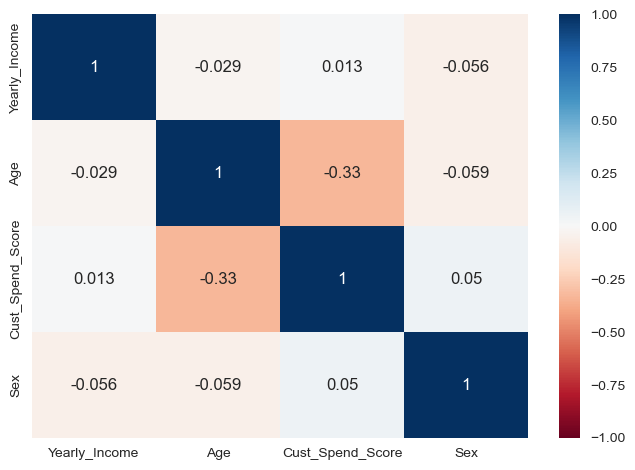

In [52]:
# make corrleation plot to see the relation among columns
sns.heatmap(df.select_dtypes(np.number).corr(),vmin=-1,annot=True,cmap='RdBu')

In [53]:
# Since customer no is unique identifier we can use it as index,so that we can identify customer indivutaly while doing business interpertation
df.set_index('Cust_Number',inplace=True)

In [54]:
# Lets seperate numerical columns so thet we can apply kmeans clustering
num_cols=df.drop(columns='Sex').columns

In [55]:
num_cols

Index(['Yearly_Income', 'Age', 'Cust_Spend_Score'], dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

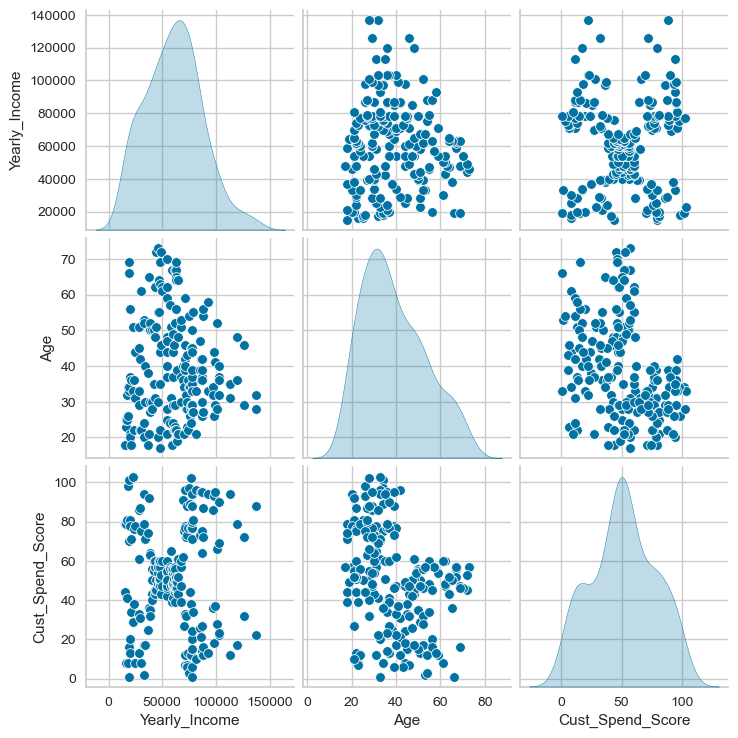

In [56]:
# univariate and bivarite analysis
sns.pairplot(data=df,vars=num_cols,diag_kind='kde')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

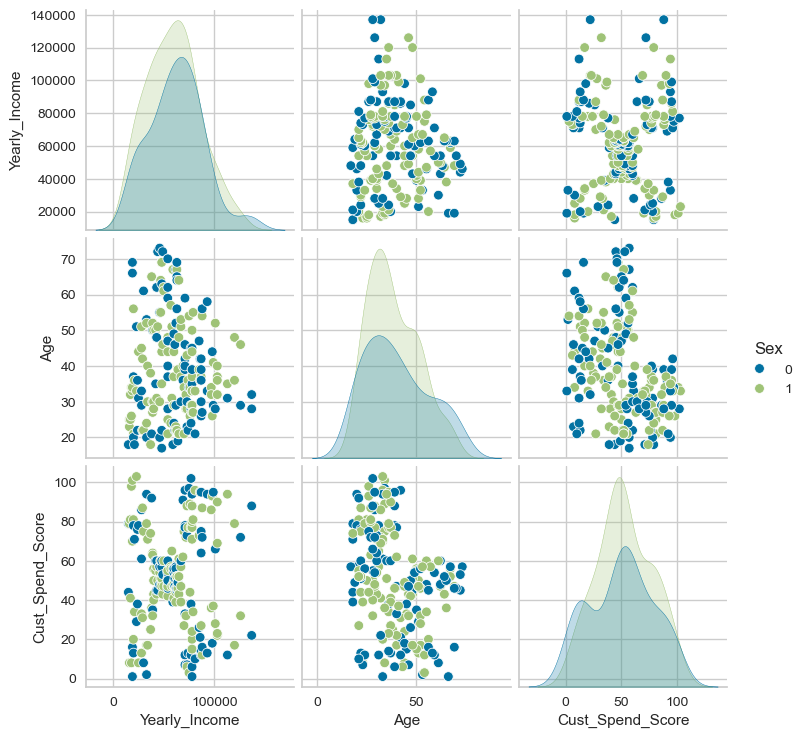

In [57]:
sns.pairplot(data=df,vars=num_cols,diag_kind='kde',hue='Sex')
plt.show()

## Data Preprocressing

### Fix the difects

#### Missing value treatment

In [58]:
# Missing value
df.isnull().sum()

Yearly_Income       0
Age                 0
Cust_Spend_Score    0
Sex                 0
dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

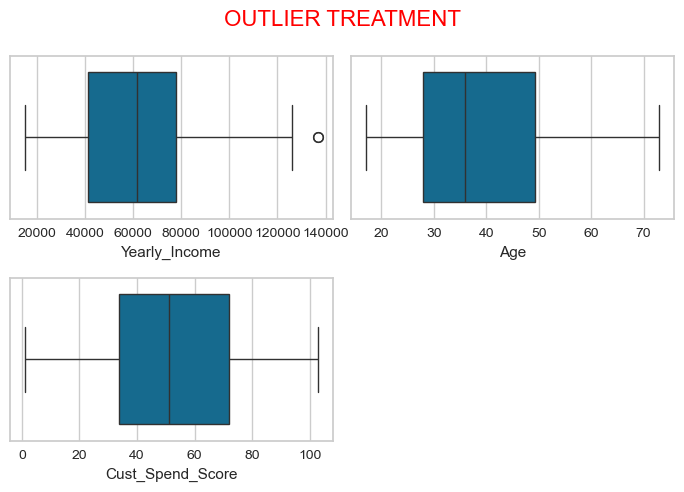

In [59]:
# treat outliers
t=1
plt.figure(figsize=(7,5))
plt.suptitle('OUTLIER TREATMENT',color='red',size=16)
for i in num_cols:
    plt.subplot(2,2,t)
    sns.boxplot(data=df,x=i)
    t+=1
plt.tight_layout()
plt.show()

In [60]:
# treat outlier --- capping
q1=df.Yearly_Income.quantile(0.25)
q3=df.Yearly_Income.quantile(0.75)
iqr=q3-q1
ul=q3+1.5*iqr
ll=q3-1.5*iqr
df.Yearly_Income=df.Yearly_Income.apply(lambda x:ul if x>ul else ll if x<ll else x)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

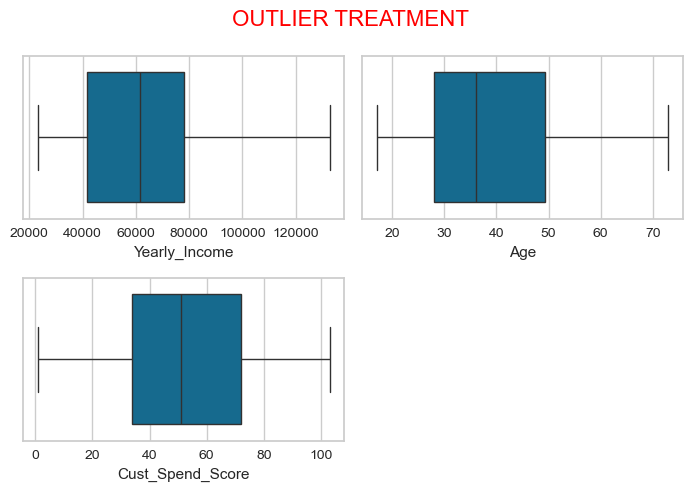

In [61]:
# After treat outliers
t=1
plt.figure(figsize=(7,5))
plt.suptitle('OUTLIER TREATMENT',color='red',size=16)
for i in num_cols:
    plt.subplot(2,2,t)
    sns.boxplot(data=df,x=i)
    t+=1
plt.tight_layout()
plt.show()

In [62]:
df.sort_values(by='Yearly_Income',ascending=False).head(3)

,Yearly_Income,Age,Cust_Spend_Score,Sex
Cust_Number,,,,
CUSTID200,132750.0,28,88,0
CUSTID199,132750.0,32,22,0
CUSTID198,126000.0,29,72,0


#### Feature scaling

In [63]:
## scaling
sc=StandardScaler()
df_scaled=sc.fit_transform(df[num_cols])

In [64]:
df_scaled=pd.DataFrame(df_scaled,columns=df[num_cols].columns)

<IPython.core.display.Javascript object>

# KMeans Clustering

In [65]:
# identify the value of K

### Elbow plot

In [66]:
df_scaled

,Yearly_Income,Age,Cust_Spend_Score
0,-1.485844,-1.501068,-0.284181
1,-1.485844,-1.501068,1.063563
2,-1.485844,-1.145280,-1.670433
3,-1.485844,-1.002965,1.063563
4,-1.485844,-0.504863,-0.399702
...,...,...,...
195,2.326032,-0.220233,1.063563
196,2.562428,0.491343,-0.746265
197,2.562428,-0.718335,0.794014
198,2.828373,-0.504863,-1.131335


In [67]:
K = range(2,11)
WCSS = []

for i in K:
    model=KMeans(n_clusters=i,random_state=0)
    model.fit(df_scaled)
    WCSS.append(model.inertia_)
WCSS

[389.6078972774012,
 292.54705115842614,
 203.57683970986147,
 166.51967921680352,
 132.91597691487146,
 117.57919267420404,
 104.5880439422931,
 94.0964486853291,
 83.9313467702887]

In [68]:
kelbow=KElbowVisualizer(estimator=KMeans(random_state=0),k=10) 

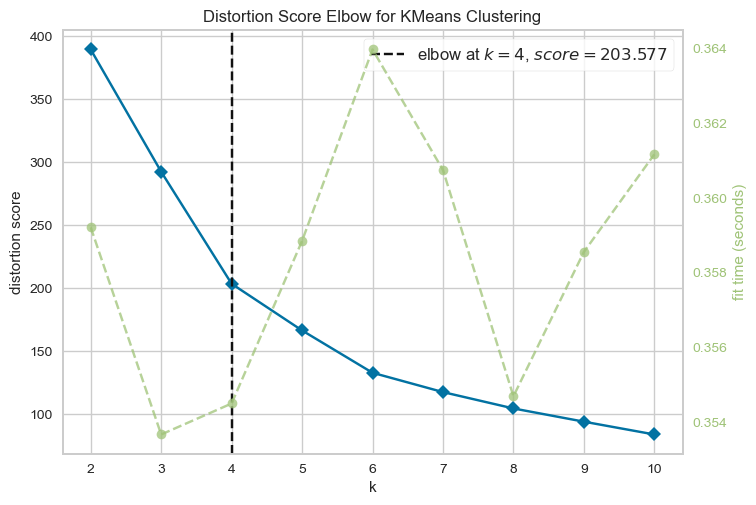

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
kelbow.fit(df_scaled)
kelbow.show() 

In [70]:
kelbow.elbow_score_

203.57683970986147

### Silhouette visualize

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

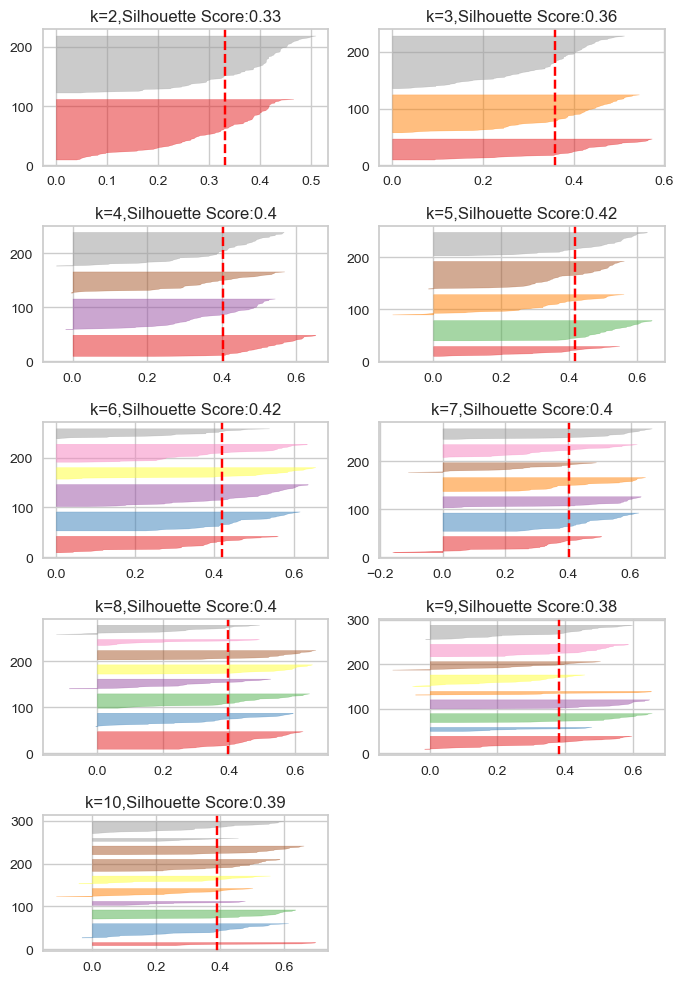

In [71]:
t=1
plt.figure(figsize=(7,10))
for i in range(2,11):
    plt.subplot(5,2,t)
    model= KMeans(n_clusters=i,random_state=0)
    sil_vis = SilhouetteVisualizer(model)
    sil_vis.fit(df_scaled)
    plt.title(f'k={i},Silhouette Score:{round(sil_vis.silhouette_score_,2)}')
    t+=1
plt.tight_layout()
plt.show()

In [72]:
# We go with K=4

## Fit the model

In [73]:
model_kmeans=KMeans(n_clusters=4,random_state=0)

In [74]:
model_kmeans.fit(df_scaled)

KMeans(n_clusters=4, random_state=0)

In [75]:
centroids=model_kmeans.cluster_centers_
centroids

array([[ 0.98621212, -0.4497156 ,  1.21373989],
       [-0.77855827, -0.93680139,  0.39881067],
       [ 0.96848246,  0.03059774, -1.14962577],
       [-0.53666606,  1.11368879, -0.40153608]])

In [76]:
labels=model_kmeans.predict(df_scaled)

In [77]:
df_scaled['labels']=labels

In [78]:
df_scaled.labels.value_counts()

labels
3    63
1    57
2    40
0    40
Name: count, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

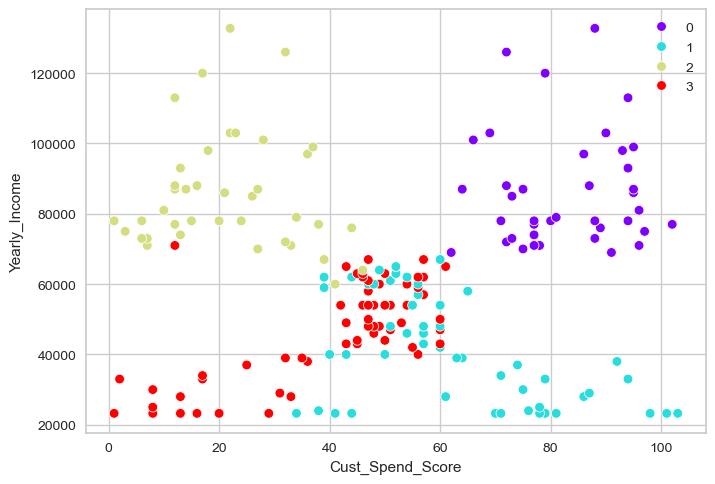

In [79]:
## visulize cluster

# yearly_income vs spent_score
sns.scatterplot(x=df.Cust_Spend_Score,y=df.Yearly_Income,hue=labels,palette='rainbow')
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

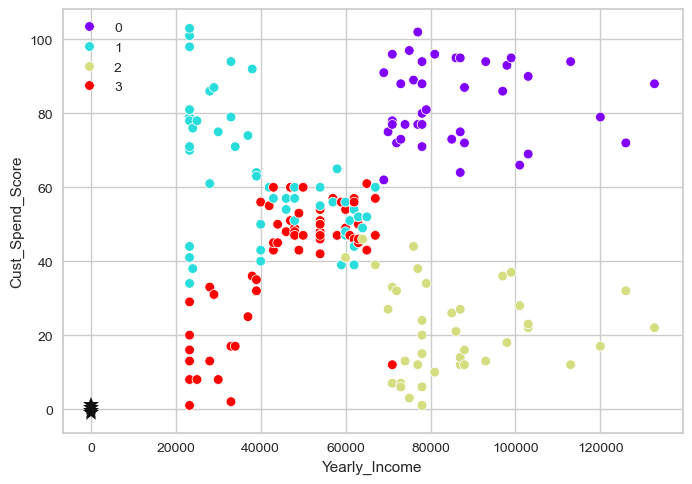

In [80]:
## show centroid as well
sns.scatterplot(y=df.Cust_Spend_Score,x=df.Yearly_Income,hue=labels,palette='rainbow')
for i in range(4):
    plt.plot(centroids[i][0],centroids[i][-1],color='k',marker='*',ms=12)
plt.show()

# Bisuness interpertation

In [81]:
df_copy.head()

,Cust_Number,Yearly_Income,Age,Cust_Spend_Score,Sex
0,CUSTID1,15000,18,44,0
1,CUSTID2,15000,18,79,0
2,CUSTID3,16000,23,8,1
3,CUSTID4,16000,25,79,1
4,CUSTID5,17000,32,41,1


In [82]:
df_copy['Kmeans_Label'] = labels

In [83]:
df_copy.groupby(by='Kmeans_Label')[num_cols].mean()

,Yearly_Income,Age,Cust_Spend_Score
Kmeans_Label,,,
0,86100.000000,32.775000,82.900000
1,40000.000000,25.929825,61.736842
2,85650.000000,39.525000,21.525000
3,47015.873016,54.746032,40.952381


In [84]:
data=pd.DataFrame(df_copy.groupby(by='Kmeans_Label')[num_cols].mean())

<IPython.core.display.Javascript object>

In [85]:
# Move the index to a column
data = data.reset_index()

# Rename the 'index' column to 'KMeans_Label' (if necessary)
data.rename(columns={'index': 'KMeans_Label'}, inplace=True)

print(data)

   Kmeans_Label  Yearly_Income        Age  Cust_Spend_Score
0             0   86100.000000  32.775000         82.900000
1             1   40000.000000  25.929825         61.736842
2             2   85650.000000  39.525000         21.525000
3             3   47015.873016  54.746032         40.952381


Cluster 0: "Luxury Spenders" – High-income, high-spending customers.
Cluster 1: "Budget Enthusiasts" – Young, budget-conscious, moderate spenders.
Cluster 2: "Potential Upscalers" – High-income customers with low spending.
Cluster 3: "Practical Shoppers" – Older, moderate-income, average-spending customers.

In [86]:
data['Kmeans_Label']=data['Kmeans_Label'].map({0:"Luxury Spenders",1:"Budget Enthusiasts",2:"Potential Upscalers",3:"Practical Shoppers"})

In [87]:
columns = [col for col in data.columns if col != 'Kmeans_Label'] + ['Kmeans_Label']
data = data[columns]

In [88]:
data=pd.DataFrame(data,columns=data.columns)
data

<IPython.core.display.Javascript object>

,Yearly_Income,Age,Cust_Spend_Score,Kmeans_Label
0,86100.000000,32.775000,82.900000,Luxury Spenders
1,40000.000000,25.929825,61.736842,Budget Enthusiasts
2,85650.000000,39.525000,21.525000,Potential Upscalers
3,47015.873016,54.746032,40.952381,Practical Shoppers


"Luxury Spenders"—focus on premium products and loyalty programs.
"Budget Enthusiasts"-spending customers—target with affordable product bundles and trendy campaigns.
"Potential Upscalers"—highlight premium offerings to increase engagement.
"Practical Shoppers"—focus on practical products and loyalty perks.

## Deployment

In [89]:
import pickle

In [90]:
# create a pickle of fittied model

with open('final_model.pkl','wb') as file:
    pickle.dump(model_kmeans,file)

In [91]:
## create a pickle of scandard scaler and pca

with open('scaler.pkl','wb') as file:
    pickle.dump(sc,file)

In [92]:
model_kmeans.predict([[86100.000000,32.775000,82.900000]])[0]

0